# Baseline simulation
This is a Jupyter notebook execution of the default performance test simulation.

In [19]:
from COVID19.model import Model, Parameters
import COVID19.simulation as simulation

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

In [20]:
sim   = simulation.Simulation(env = model, end_time = 200 )
sim.steps( 200 )

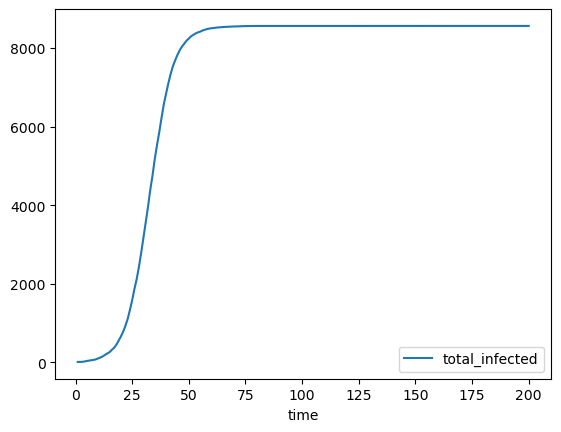

In [21]:
import pandas as pd
timeseries = pd.DataFrame( sim.results )
timeseries.plot( x = "time", y = "total_infected" )

## Extract network settings
We want to see how the probability of a person in each network becoming infected changes over time. Let us calculate the mean and variance for this probability for each network over the number of days in the simulation.

By default the model calculates the infectiousness hazard rate (the probability you will be infected by this interaction with this ill individual) from the network's combined transmission multiplier multiplied by the infector's infectiousness multiplier multipled by the strains infectiousness multiplied by the infectiousness for this strain on this day of infectiousness (i.e. the specific part of the infectiousness curve at this point in time). This is the interaction hazard value. See ../src/disease.c:111 transmit_virus_by_type() for details.

The strain infectious curve is a gamma_rate_curve distribution. See ../src/strain.c:42 initialise_infectious_curves(). This is static for a given day of being infectious as it's the same throughout the simulation for this strain.

The network transmission multiplier comes from a parameter for the simulation and is static throughout the simulation by the type of network. In the baseline parameters, for example, it is X for a household network, Y for a random network, and Z for a work network. See baseline_parameters.csv relative_transmission_household, relative_transmission_occupation, and relative_transmission_random parameters

The initial individual hazard probability is taken from the exponential distribution and is static for each individual throughout the whole simulation. This is divided by the adjusted susceptibility for that person's age group when setting up the simulation.

If the individual's static hazard value is less than this network interactions hazard value, then the individual is deemed to now be infected. See the new_infection() call in ../src/disease.c:174 transmit_virus_by_type() function.

All interactions throughout all networks of the same type thus have a static infectiousness multiplier which is only changed by the infectiousness of an individual in that network based on the number of days that individual has been infectious. Removing this from consideration, our network transmission multiplier values should be:-

Network | Mean Infectiousness | Variance of infectiousness
---|---|---
Work | 1 | 0
Home | 2 | 0
Random | 1 | 0

Let us try to calculate this from the model itself... (we'll calculate it over time even though we know its static so the code remains the same for future changes).


### Calculate mean and variance of infectiousness of all interactions across all networks of the same type
We expect to see the above table reproduced.
There will be no change to the number of infected.

Mean of r0 estimate:  1.2732042491825757 , variance of r0 estimate:  0.3513052368448024 , Max R0:  3.3416058394160584
WORK:     Count of networks:  5.0 , Mean:  1.0 , Variance:  0.0
HOME:     Count of networks:  1.0 , Mean:  2.0 , Variance:  0.0
RANDOM:   Count of networks:  1.0 , Mean:  1.0 , Variance:  0.0


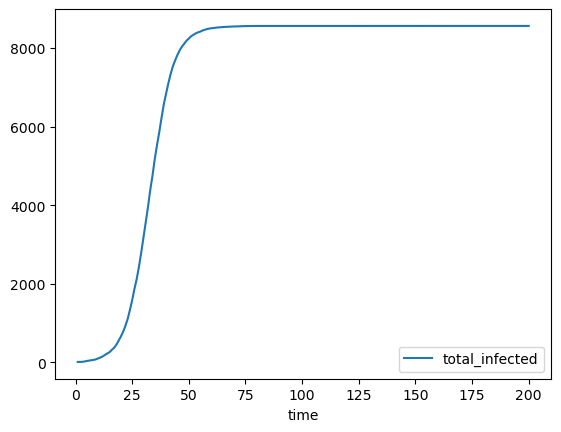

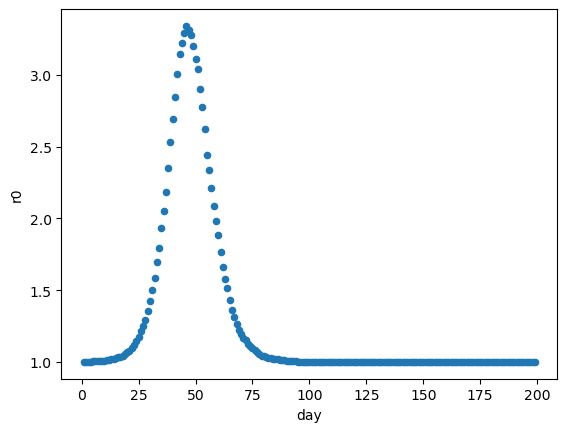

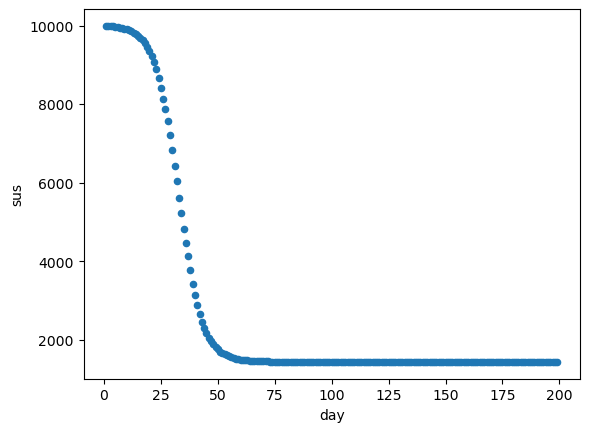

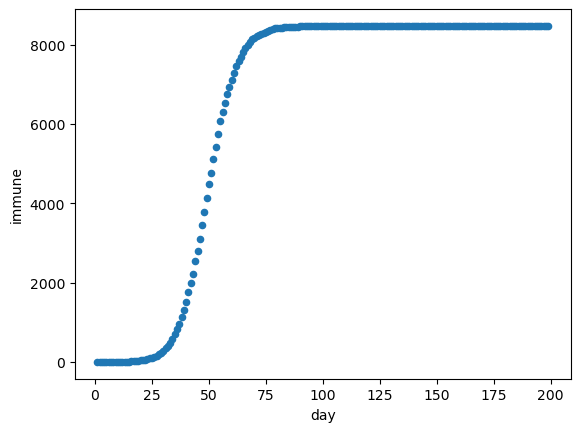

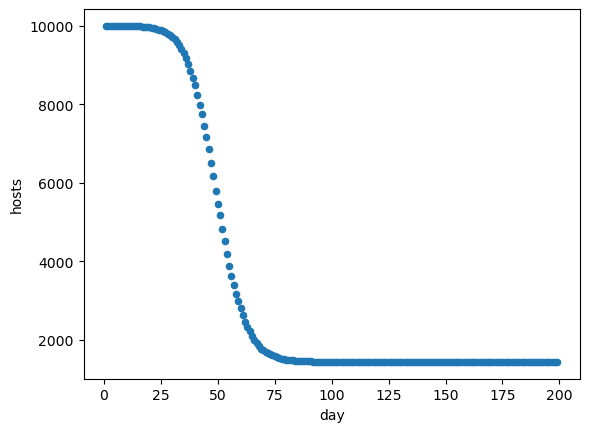

In [23]:
import numpy as np

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
    
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious or recovering
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
    

    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
        
    
timeseriesBaseline = pd.DataFrame( sim.results )
timeseriesBaseline.plot( x = "time", y = "total_infected" )

r0Baseline = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Baseline.plot('day','r0', kind = 'scatter')

xnBaselineSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnBaselineSus.plot('day','sus',kind='scatter')
xnBaselineImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnBaselineImmune.plot('day','immune',kind='scatter')
xnBaselineHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnBaselineHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")

countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now change the multiplier to be completely random every simulation step from a uniform distribution
We expect to see a uniform distribution, and thus a mean of 0.5 and a standard deviation of 0.08333.
The overall number of infected may well change, as now the overall probability distribution across all interactions will be different from the three network types' fixed values.

Mean of r0 estimate:  1.0666810346566193 , variance of r0 estimate:  0.008289647020070208 , Max R0:  1.2905540720961282
WORK:     Count of networks:  5.0 , Mean:  0.48899593214457854 , Variance:  0.08433993907653371
HOME:     Count of networks:  1.0 , Mean:  1.0614509675127919 , Variance:  0.34641498478171096
RANDOM:   Count of networks:  1.0 , Mean:  0.4976471328828484 , Variance:  0.07897214733051477


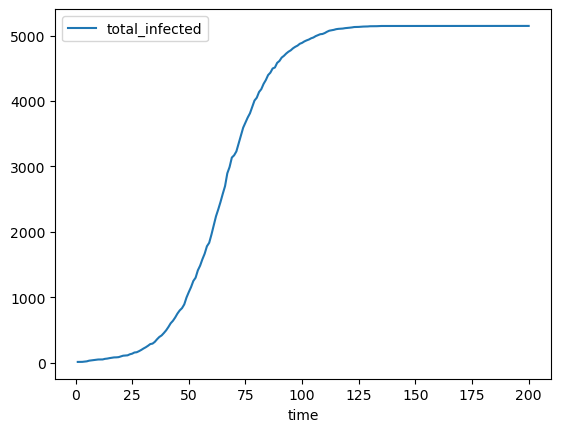

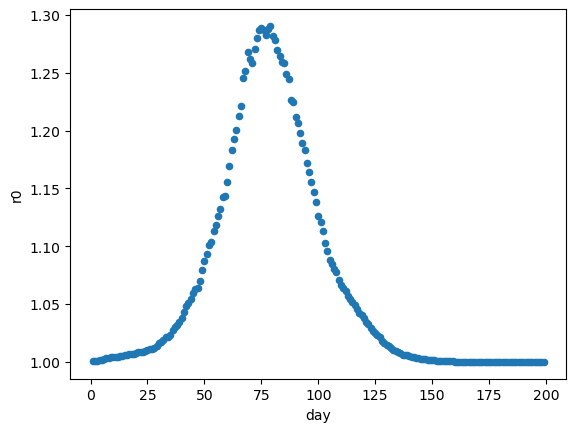

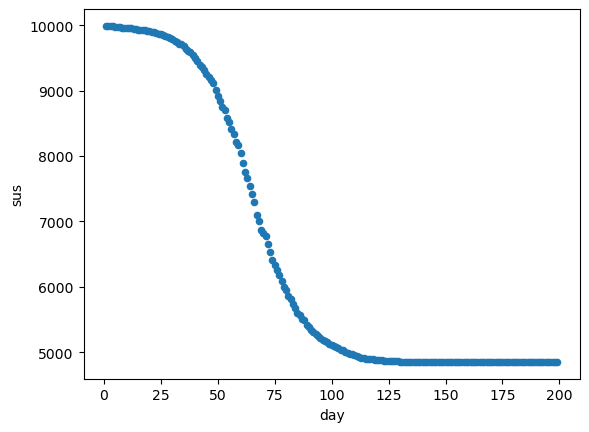

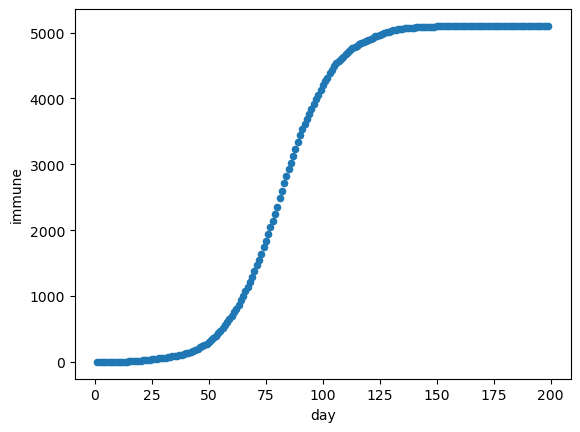

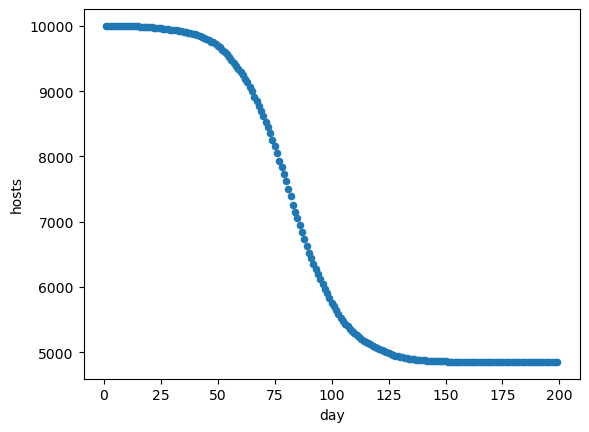

In [24]:
import numpy as np

from scipy.stats import uniform 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = uniform.rvs(0.0,1.0)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
    
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious or recovering
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
        
timeseriesUniform = pd.DataFrame( sim.results )
timeseriesUniform.plot( x = "time", y = "total_infected" )

r0Uniform = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Uniform.plot('day','r0', kind = 'scatter')

xnUniformSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnUniformSus.plot('day','sus',kind='scatter')
xnUniformImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnUniformImmune.plot('day','immune',kind='scatter')
xnUniformHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnUniformHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    


# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now do the same but from a Gamma distribution and random every simulation step
We expect to see the same mean and variance at a population level with the gamma distribution with Scale 1.

We expect to see more infections earlier on due to the skewness of the CDF of the gamma distribution when compared to a uniform distribution.

Mean of r0 estimate:  1.3162758344258836 , variance of r0 estimate:  0.4920511322450865 , Max R0:  3.8409371146732427
WORK:     Count of networks:  5.0 , Mean:  1.030494209174125 , Variance:  1.1096021051327236
HOME:     Count of networks:  1.0 , Mean:  1.9155074888258241 , Variance:  3.2259485577647653
RANDOM:   Count of networks:  1.0 , Mean:  1.163161801277456 , Variance:  1.4373148319557134


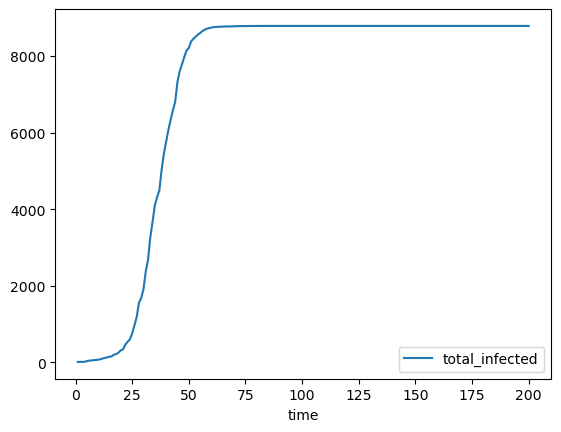

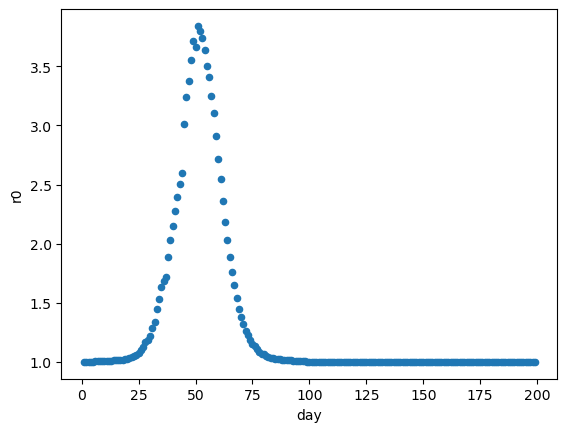

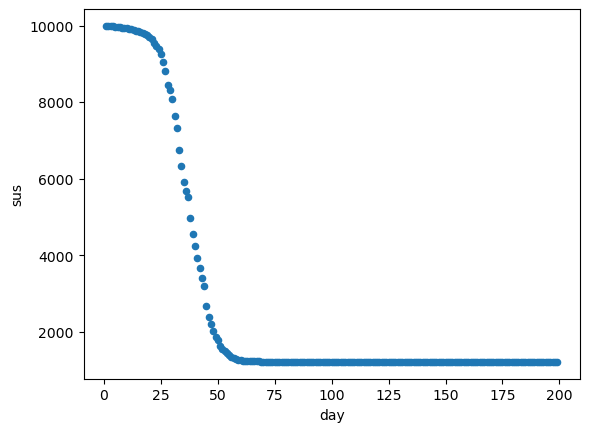

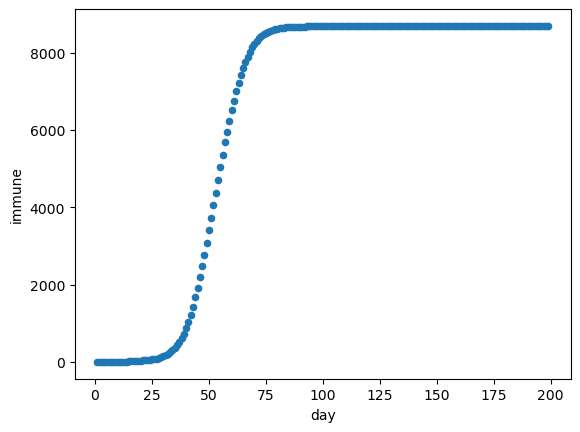

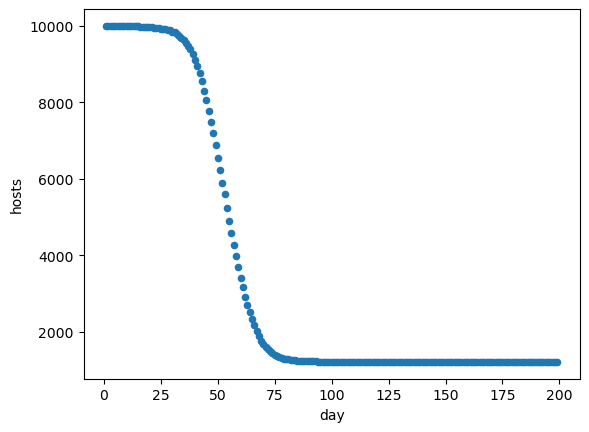

In [25]:
import numpy as np

from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
params.set_param( "n_total", 10000)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

for b in range(1,201):
    # Modify network probabilities each step
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        
        randomValue = gamma.rvs(1,scale=1)
        
        network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
    
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesGamma = pd.DataFrame( sim.results )
timeseriesGamma.plot( x = "time", y = "total_infected" )

r0Gamma = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Gamma.plot('day','r0', kind = 'scatter')

xnGammaSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnGammaSus.plot('day','sus',kind='scatter')
xnGammaImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnGammaImmune.plot('day','immune',kind='scatter')
xnGammaHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnGammaHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    


# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now create multiple network instances of the same type and see if it produces the same results
We want to move to a model where an individuals workplace is modelled exactly. This means we need multiple home and work networks simulated with different transmission probabilities rather than a single work instance with the same one and just a proportion of mixing happening within the network.
Let us modify the model to have 200 work places and 4000 homes but keep the 5 random networks. Let us use the same fixed probabilities as the original baseline parameters.
We should see the same infection curve as the baseline model with the same means and zero variance.

Network state from parameters file:-
Network 0 is a Random network
Network 1 is a Home network
Network 2 is a Work network
Network 3 is a Work network
Network 4 is a Work network
Network 5 is a Work network
Network 6 is a Work network
Network state after modification:-
Network 0 is a Random network
Network 1 is a Home network
Network 2 is a Work network
Network 3 is a Work network
Network 4 is a Work network
Network 5 is a Work network
Network 6 is a Work network
Network 7 is a Work network
Network 8 is a Work network
Network 9 is a Work network
Network 10 is a Work network
Network 11 is a Work network
Network 12 is a Work network
Network 13 is a Work network
Network 14 is a Work network
Network 15 is a Work network
Network 16 is a Work network
Network 17 is a Work network
Network 18 is a Work network
Network 19 is a Work network
Network 20 is a Work network
Network 21 is a Work network
Mean of r0 estimate:  1.2834329357918566 , variance of r0 estimate:  0.3980027489755987 , Max R0:  3

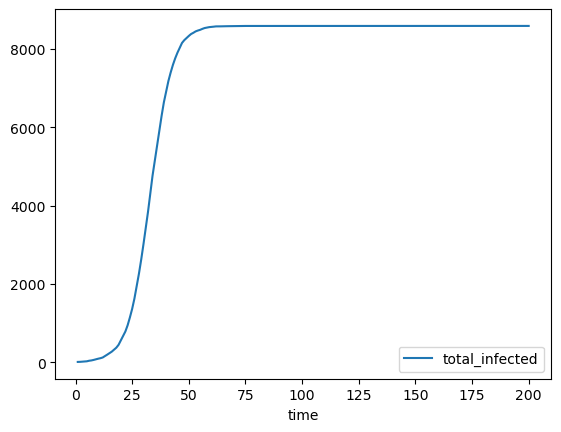

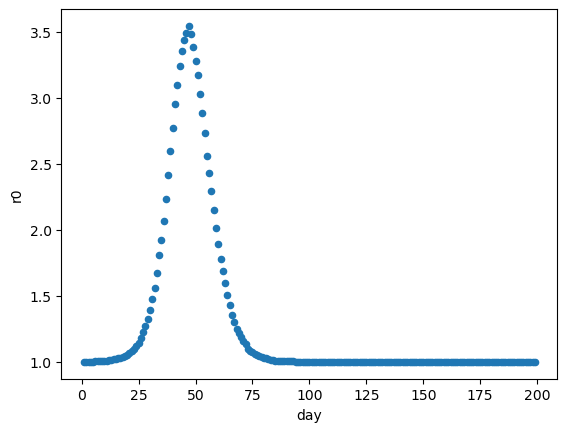

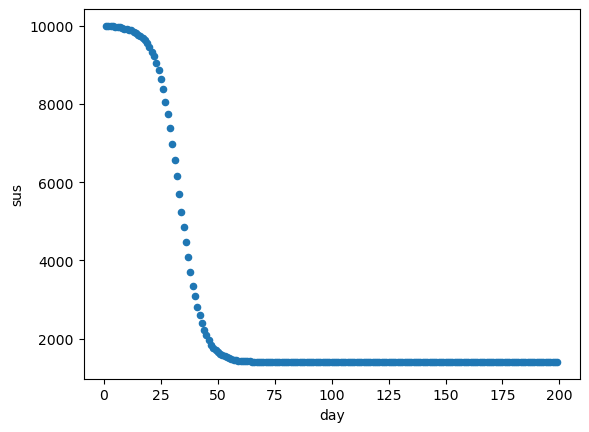

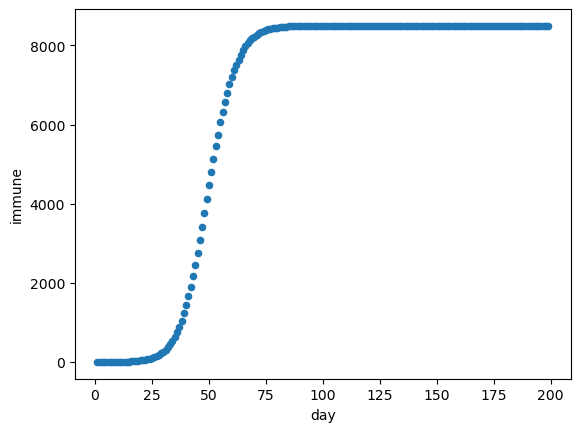

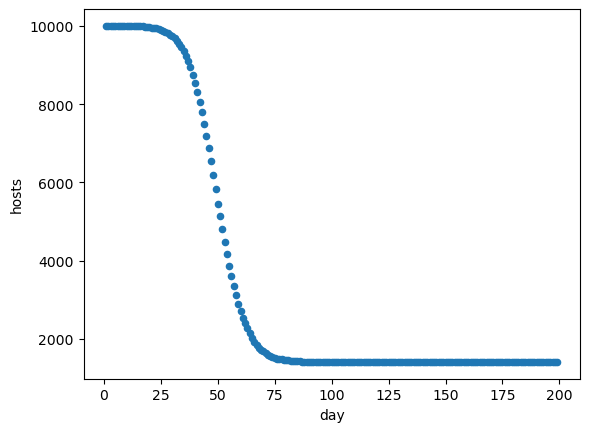

In [26]:
import numpy as np
import example_utils as utils
from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []

# These are from the baseline parameters csv file - mean_*_interactions_adult parameters
meanWorkInteraction = 7
meanHomeInteraction = 4
meanRandomInteraction = 4

# Print existing network info:-
print("Network state from parameters file:-")
for networkId in range(0,underlyingModel.c_model.n_networks):
    network = underlyingModel.get_network_by_id(networkId)

    if network.type() == 0:
        print("Network",networkId,"is a Home network")
    elif network.type() == 1:
        print("Network",networkId,"is a Work network")
    elif network.type() == 2:
        print("Network",networkId,"is a Random network")
    else: 
        print("Network",networkId,"is something else")


        
        
        
        

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

# REMOVE ALL DEFAULT NETWORKS
# Note: We cannot currently delete parameters from the Parameter object in OpenABM-Covid19
        
# Duplicate initial networks, and if work or occupation network, create 20x the number
# doneHome = False
# doneWork = False
# for networkId in range(0,underlyingModel.c_model.n_networks):
#     network = underlyingModel.get_network_by_id(networkId)
#     if network.type() == 0 and not doneHome:
#         doneHome = True
#         # Home network - create 19 copies, each with a different probability
#         n_total = network.n_vertices() / 20
#         parameters = params
#         for nc in range(1,20):
#             newNetwork = underlyingModel.create_network(n_total,network.type(),parameters)
# #             randomValue = gamma.rvs(1,scale=1)
# #             newNetwork.set_network_transmission_multiplier(randomValue)
#         # Modify original network
#         network.n_vertices = n_total
        
# #     elif network.type() == 1:
#         # Do nothing - keep 5!
#         #
#     elif network.type() != 0 and network.type() != 1 and not doneWork:
#         doneWork = True
#         # Work network - create 19 copies, each with a different probability
#         n_total = network.n_vertices() / 20
#         parameters = params
#         for nc in range(1,20):
#             newNetwork = underlyingModel.create_network(n_total,network.type(),parameters)
# #             randomValue = gamma.rvs(1,scale=1)
# #             newNetwork.set_network_transmission_multiplier(randomValue)
#         # Modify original network
#         network.n_vertices = n_total

n_networks = 20
network_no = np.arange(n_networks)
network_name = np.array(['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10','e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20'])
age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
mean_work_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
lockdown_multiplier = np.ones(n_networks) * 0.33 # From parameters file lockdown_occupation_multiplier_*_network

occupation_networks = pd.DataFrame({
    'network_no': network_no,
    'age_type': age_type,
    'mean_work_interaction': mean_work_interaction,
    'lockdown_multiplier': lockdown_multiplier,
    'network_id': network_no,
    'network_name': network_name,
})
IDs = np.arange(n_total)
assignment = np.random.randint(0, n_networks, n_total)
occupation_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
params.set_occupation_network_table(occupation_network_assignment, occupation_networks)



# WARNING - THE ABOVE EFFECTIVELY REMOVES ALL NETWORKS WITH IDS < 20 - ALL THE ORIGINAL NETWORKS!
# Need something like params.set_demographic_house_table(n_total,...) but which allocates the people like occupation network call above


# Now home networks - FUNCTIONALITY NOT AVAILABLE WITHIN OPENABM COVID19 TODAY!

# n_networks = 20
# network_no = 20 + np.arange(n_networks)
# network_name = np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10','h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20'])
# age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
# mean_home_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
# lockdown_multiplier = np.ones(n_networks) * 0.22

# home_networks = pd.DataFrame({
#     'network_no': network_no,
#     'age_type': age_type,
#     'mean_work_interaction': mean_home_interaction,
#     'lockdown_multiplier': lockdown_multiplier,
#     'network_id': network_no,
#     'network_name': network_name,
# })
# IDs = 20 + np.arange(n_total)
# assignment = np.random.randint(0, n_networks, n_total)
# home_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
# params.set_home_network_table(home_network_assignment, home_networks)






# model = simulation.COVID19IBM(model = Model(params))
# Reload parameters (otherwise you get an 'already loaded into model' error)
sim = utils.get_simulation( params )
underlyingModel = sim.env.model

for b in range(1,201):
    # Modify network probabilities each step
    if (1 == b):
        print("Network state after modification:-")
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
        if (1 == b):
            if network.type() == 0:
                print("Network",networkId,"is a Home network")
            elif network.type() == 1:
                print("Network",networkId,"is a Work network")
            elif network.type() == 2:
                print("Network",networkId,"is a Random network")
            else: 
                print("Network",networkId,"is something else")
        
#         randomValue = gamma.rvs(1,scale=1)
        
#         network.set_network_transmission_multiplier(randomValue)
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
        
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesMulti = pd.DataFrame( sim.results )
timeseriesMulti.plot( x = "time", y = "total_infected" )

r0Multi = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0Multi.plot('day','r0', kind = 'scatter')

xnMultiSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnMultiSus.plot('day','sus',kind='scatter')
xnMultiImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnMultiImmune.plot('day','immune',kind='scatter')
xnMultiHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnMultiHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    


# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now reintroduce the Gamma distribution
We now modify the networks so they use the gamma distribution (shape=1), but with a transmission probability fixed for each network instance (not network type as in the baseline) at the start of the simulation, but with many more networks.
Again we expect to see the same infection curve but with variance matching our previous gamma model (0.0367) and mean for the distribution (~1.0).

Mean of r0 estimate:  1.2020671989580685 , variance of r0 estimate:  0.20297133194552044 , Max R0:  2.780614132445431
WORK:     Count of networks:  200.0 , Mean:  1.010714563397772 , Variance:  0.879305916255139
HOME:     Count of networks:  1.0 , Mean:  2.0 , Variance:  0.0
RANDOM:   Count of networks:  1.0 , Mean:  1.0 , Variance:  0.0


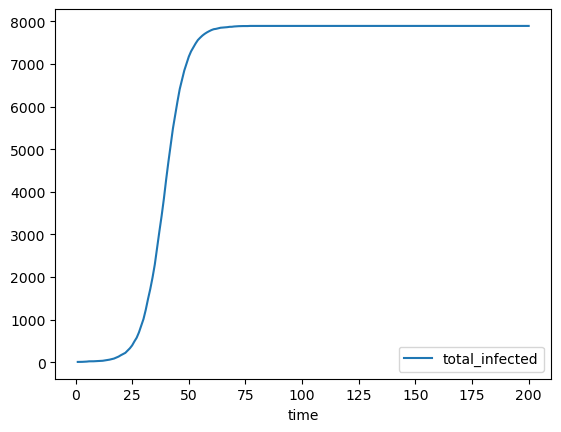

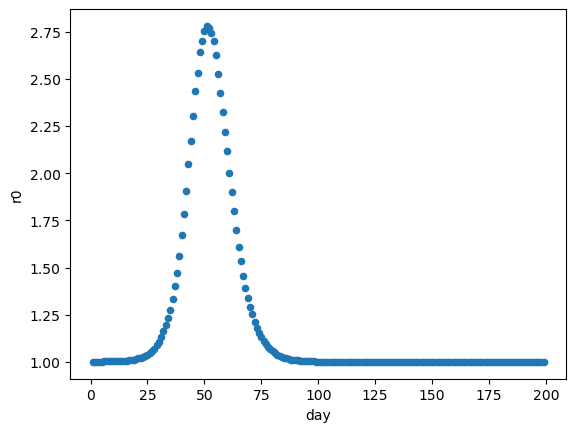

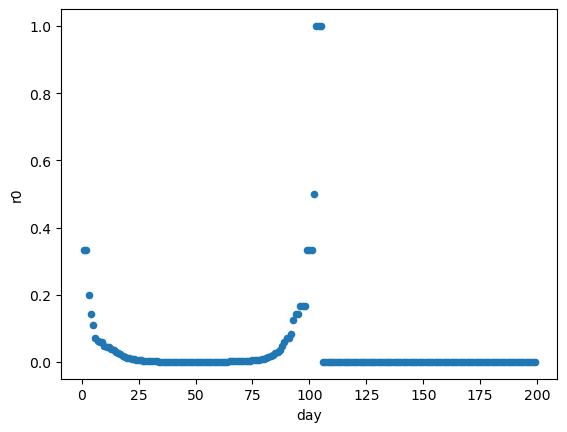

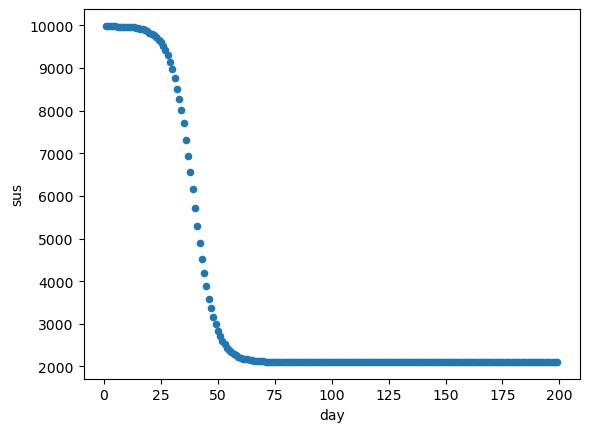

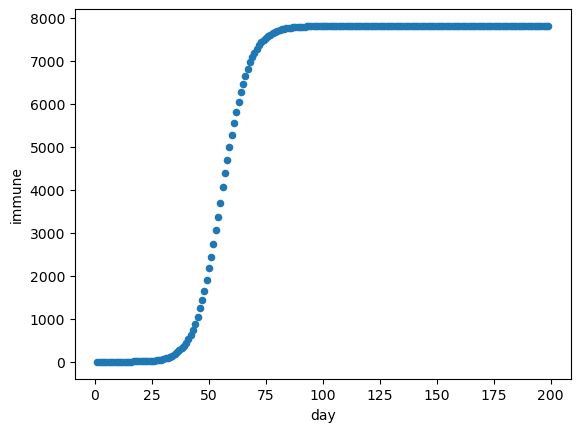

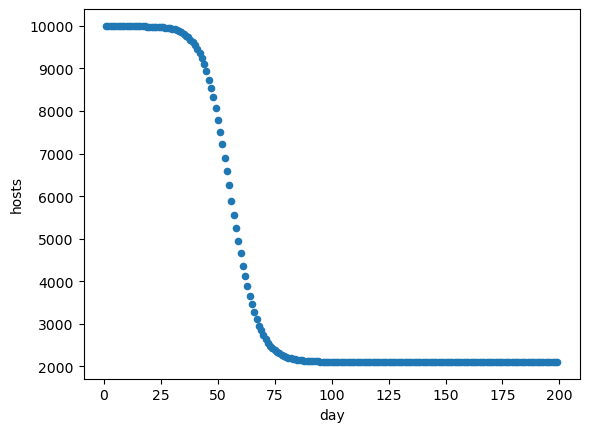

In [34]:
import numpy as np
import example_utils as utils
from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
infectiousPerDay = []
hostsPerDay = []
r0PerDay = []
r0InfPerDay = []

# These are from the baseline parameters csv file - mean_*_interactions_adult parameters
meanWorkInteraction = 7
meanHomeInteraction = 4
meanRandomInteraction = 4

# Print existing network info:-
# print("Network state from parameters file:-")
# for networkId in range(0,underlyingModel.c_model.n_networks):
#     network = underlyingModel.get_network_by_id(networkId)

#     if network.type() == 0:
#         print("Network",networkId,"is a Home network")
#     elif network.type() == 1:
#         print("Network",networkId,"is a Work network")
#     elif network.type() == 2:
#         print("Network",networkId,"is a Random network")
#     else: 
#         print("Network",networkId,"is something else")

 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

# REMOVE ALL DEFAULT NETWORKS
# Note: We cannot currently delete parameters from the Parameter object in OpenABM-Covid19
#       So we just overwrite them instead

n_networks = 200
network_no = np.arange(n_networks)
network_name_array = []
age_type_array = []
mean_work_interaction_array = []
for i in range (1,1 + n_networks):
    network_name_array.append("e" + str(i))
    age_type_array.append(1)
    mean_work_interaction_array.append(meanWorkInteraction)
network_name = np.array(network_name_array)
age_type = np.array(age_type_array) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
mean_work_interaction = np.array(mean_work_interaction_array)
lockdown_multiplier = np.ones(n_networks) * 0.33 # From parameters file lockdown_occupation_multiplier_*_network

occupation_networks = pd.DataFrame({
    'network_no': network_no,
    'age_type': age_type,
    'mean_work_interaction': mean_work_interaction,
    'lockdown_multiplier': lockdown_multiplier,
    'network_id': network_no,
    'network_name': network_name,
})
IDs = np.arange(n_total)
assignment = np.random.randint(0, n_networks, n_total)
occupation_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
params.set_occupation_network_table(occupation_network_assignment, occupation_networks)



# WARNING - THE ABOVE EFFECTIVELY REMOVES ALL NETWORKS WITH IDS < 20 - ALL THE ORIGINAL NETWORKS!
# Need something like params.set_demographic_house_table(n_total,...) but which allocates the people like occupation network call above


# Now home networks - FUNCTIONALITY NOT AVAILABLE WITHIN OPENABM COVID19 TODAY!

# n_networks = 20
# network_no = 20 + np.arange(n_networks)
# network_name = np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10','h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20'])
# age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
# mean_home_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
# lockdown_multiplier = np.ones(n_networks) * 0.22

# home_networks = pd.DataFrame({
#     'network_no': network_no,
#     'age_type': age_type,
#     'mean_work_interaction': mean_home_interaction,
#     'lockdown_multiplier': lockdown_multiplier,
#     'network_id': network_no,
#     'network_name': network_name,
# })
# IDs = 20 + np.arange(n_total)
# assignment = np.random.randint(0, n_networks, n_total)
# home_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
# params.set_home_network_table(home_network_assignment, home_networks)




# model = simulation.COVID19IBM(model = Model(params))
# Reload parameters (otherwise you get an 'already loaded into model' error)
sim = utils.get_simulation( params )
underlyingModel = sim.env.model

# Pre-select all probabilities
probs = []
for networkId in range(0,underlyingModel.c_model.n_networks):
    probs.append(gamma.rvs(1,scale=1))
    
for b in range(1,201):
    # Modify network probabilities each step
#     if (1 == b):
#         print("Network state after modification:-")
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
#         if (1 == b):
#             if network.type() == 0:
#                 print("Network",networkId,"is a Home network")
#             elif network.type() == 1:
#                 print("Network",networkId,"is a Work network")
#             elif network.type() == 2:
#                 print("Network",networkId,"is a Random network")
#             else: 
#                 print("Network",networkId,"is something else")
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            valuesWork.append(network.transmission_multiplier_combined())
                
            randomValue = probs[networkId]
            network.set_network_transmission_multiplier(randomValue)
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
        
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    infectiousBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus == 3) or (indivStatus == 4) or (indivStatus == 5):
            # Infectious
            infectiousBar += 1
            nBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        infectiousPerDay.append(infectiousBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
        if (xBar != 0) and (infectiousBar != 0):
            r0InfPerDay.append(nBar / (xBar * infectiousBar))
        else:
            r0InfPerDay.append(0)
              
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesMultiStart = pd.DataFrame( sim.results )
timeseriesMultiStart.plot( x = "time", y = "total_infected" )

r0MultiStart = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0MultiStart.plot('day','r0', kind = 'scatter')

r0InfMultiStart = pd.DataFrame({'day': range(1,200), 'r0': r0InfPerDay})
r0InfMultiStart.plot('day','r0', kind = 'scatter')

xnMultiStartSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnMultiStartSus.plot('day','sus',kind='scatter')
xnMultiStartImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnMultiStartImmune.plot('day','immune',kind='scatter')
xnMultiStartHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnMultiStartHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    

    

# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

### Now change the random value to be a weighting from a given mean in the parameter file
We now modify the simulation so the randomness of infection probability lies between being fixed per network type and random for every interaction for every network instance. 
We will use the simulation parameter network transmissability number and treat it as the mean for the chosen distribution, then use the distribution per network instance at the start of the simulation to generate a per network transmissibility number. I.e. it is weighted.
We expect the mean to be the same as the original parameter, but the variance to be the same as the previous gamma set at start simulation.

Mean of r0 estimate:  1.2367812496053388 , variance of r0 estimate:  0.27298751061523696 , Max R0:  3.067335842743622
WORK:     Count of networks:  200.0 , Mean:  0.991946958899498 , Variance:  0.4743467022956348
HOME:     Count of networks:  1.0 , Mean:  2.0 , Variance:  0.0
RANDOM:   Count of networks:  1.0 , Mean:  1.0 , Variance:  0.0


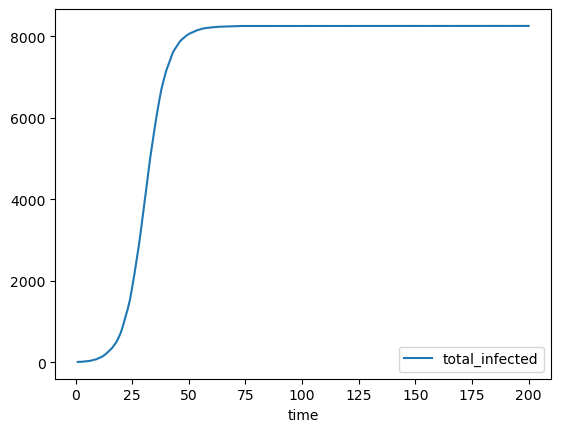

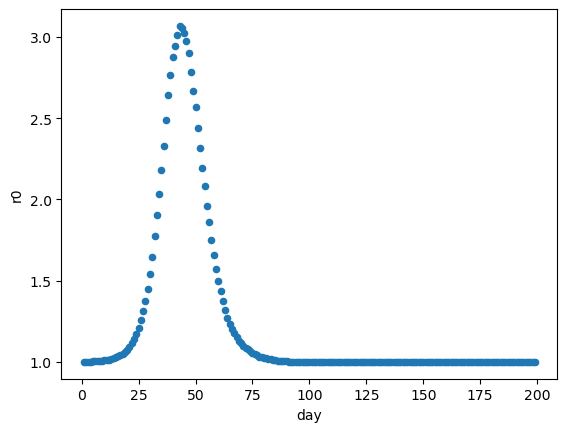

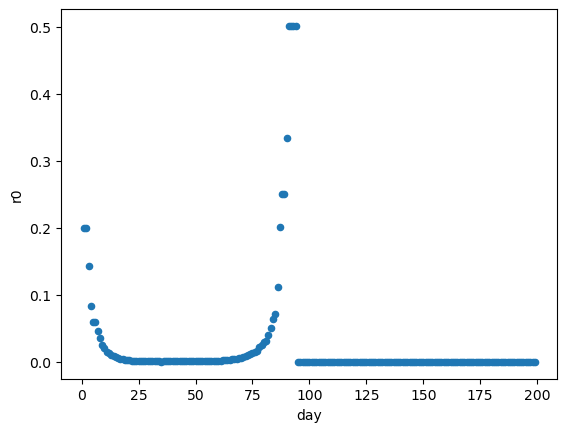

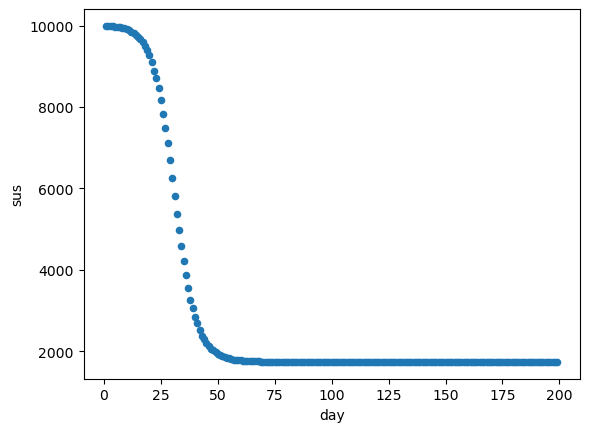

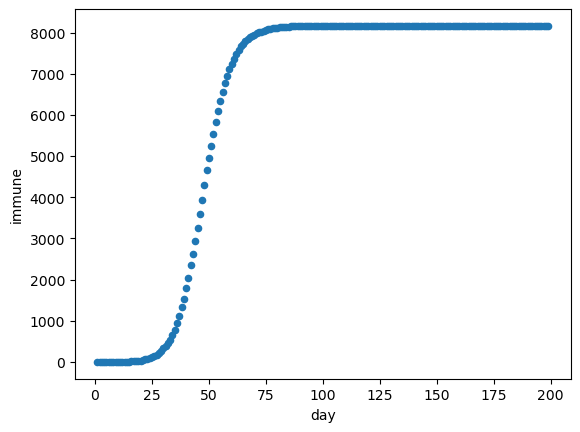

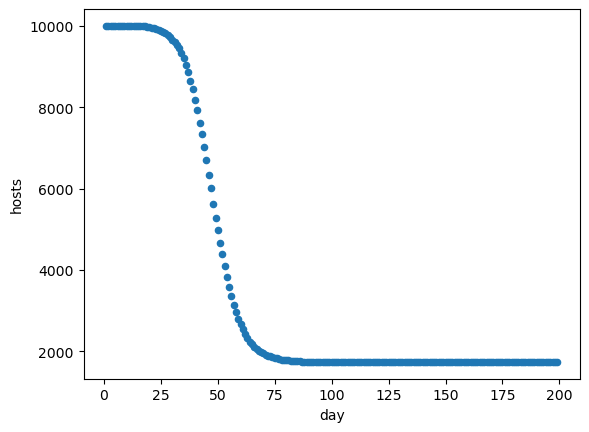

In [35]:
import numpy as np
import example_utils as utils
from scipy.stats import gamma 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

model = simulation.COVID19IBM(model = Model(params))

sim   = simulation.Simulation(env = model, end_time = 200 )

underlyingModel = sim.env.model

randomValue = 0

valuesWork = []
valuesHome = []
valuesRandom = []

susceptiblesPerDay = []
immunePerDay = []
hostsPerDay = []
r0PerDay = []
r0InfPerDay = []

# These are from the baseline parameters csv file - mean_*_interactions_adult parameters
meanWorkInteraction = 7
meanHomeInteraction = 4
meanRandomInteraction = 4

# Print existing network info:-
# print("Network state from parameters file:-")
# for networkId in range(0,underlyingModel.c_model.n_networks):
#     network = underlyingModel.get_network_by_id(networkId)

#     if network.type() == 0:
#         print("Network",networkId,"is a Home network")
#     elif network.type() == 1:
#         print("Network",networkId,"is a Work network")
#     elif network.type() == 2:
#         print("Network",networkId,"is a Random network")
#     else: 
#         print("Network",networkId,"is something else")

 

params = Parameters(
    input_param_file="../tests/data/baseline_parameters.csv",
    param_line_number=1,
    output_file_dir="../data_test",
    input_households="../tests/data/baseline_household_demographics.csv"
)
n_total = 10000
params.set_param( "n_total", n_total)

# REMOVE ALL DEFAULT NETWORKS
# Note: We cannot currently delete parameters from the Parameter object in OpenABM-Covid19
#       So we just overwrite them instead

n_networks = 200
network_no = np.arange(n_networks)
network_name_array = []
age_type_array = []
mean_work_interaction_array = []
for i in range (1,1 + n_networks):
    network_name_array.append("e" + str(i))
    age_type_array.append(1)
    mean_work_interaction_array.append(meanWorkInteraction)
network_name = np.array(network_name_array)
age_type = np.array(age_type_array) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
mean_work_interaction = np.array(mean_work_interaction_array)
lockdown_multiplier = np.ones(n_networks) * 0.33 # From parameters file lockdown_occupation_multiplier_*_network

occupation_networks = pd.DataFrame({
    'network_no': network_no,
    'age_type': age_type,
    'mean_work_interaction': mean_work_interaction,
    'lockdown_multiplier': lockdown_multiplier,
    'network_id': network_no,
    'network_name': network_name,
})
IDs = np.arange(n_total)
assignment = np.random.randint(0, n_networks, n_total)
occupation_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
params.set_occupation_network_table(occupation_network_assignment, occupation_networks)



# WARNING - THE ABOVE EFFECTIVELY REMOVES ALL NETWORKS WITH IDS < 20 - ALL THE ORIGINAL NETWORKS!
# Need something like params.set_demographic_house_table(n_total,...) but which allocates the people like occupation network call above


# Now home networks - FUNCTIONALITY NOT AVAILABLE WITHIN OPENABM COVID19 TODAY!

# n_networks = 20
# network_no = 20 + np.arange(n_networks)
# network_name = np.array(['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10','h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20'])
# age_type = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]) # 0 - AGE_TYPE_CHILD, 1 - AGE_TYPE_ADULT, 2 - AGE_TYPE_ELDERLY
# mean_home_interaction = np.array([7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7])
# lockdown_multiplier = np.ones(n_networks) * 0.22

# home_networks = pd.DataFrame({
#     'network_no': network_no,
#     'age_type': age_type,
#     'mean_work_interaction': mean_home_interaction,
#     'lockdown_multiplier': lockdown_multiplier,
#     'network_id': network_no,
#     'network_name': network_name,
# })
# IDs = 20 + np.arange(n_total)
# assignment = np.random.randint(0, n_networks, n_total)
# home_network_assignment  = pd.DataFrame({'ID':IDs, 'network_no':assignment})
# params.set_home_network_table(home_network_assignment, home_networks)




# model = simulation.COVID19IBM(model = Model(params))
# Reload parameters (otherwise you get an 'already loaded into model' error)
sim = utils.get_simulation( params )
underlyingModel = sim.env.model

# Pre-select all probabilities
probs = []
for networkId in range(0,underlyingModel.c_model.n_networks):
    probs.append(1.00 + (0.66*(gamma.rvs(1,scale=1) - 1))) # i.e. 1 (original mean) +/- 0.33 (mean, from params file)
    
for b in range(1,201):
    # Modify network probabilities each step
#     if (1 == b):
#         print("Network state after modification:-")
    for networkId in range(0,underlyingModel.c_model.n_networks):
        network = underlyingModel.get_network_by_id(networkId)
#         if (1 == b):
#             if network.type() == 0:
#                 print("Network",networkId,"is a Home network")
#             elif network.type() == 1:
#                 print("Network",networkId,"is a Work network")
#             elif network.type() == 2:
#                 print("Network",networkId,"is a Random network")
#             else: 
#                 print("Network",networkId,"is something else")
        
        if network.type() == 0:
            valuesHome.append(network.transmission_multiplier_combined())
        elif network.type() == 1:
            # Only modification work networks now
            randomValue = probs[networkId]
            network.set_network_transmission_multiplier(randomValue)
            
            valuesWork.append(network.transmission_multiplier_combined())
        elif network.type() == 2:
            valuesRandom.append(network.transmission_multiplier_combined())
        # See constant.h:155 INTERACTION_TYPE enum for other types (hospital networks)
                    
            
    # Calculate R0 estimate - R = 1/ x* = 1 / (X / N) = N / X (equilibrium),
    # where N is total number of hosts, X is susceptible hosts
    # from Anderson & May Chapter 4 page 69 (The basic model: statics)
    xBar = 0
    nBar = 0
    immuneBar = 0
    infectiousBar = 0
    indivs = underlyingModel.get_individuals()
    for indivId in range(n_total):
        indivStatus = indivs.current_status[indivId]
        if indivStatus == 0:
            # Susceptible
            xBar += 1
            nBar += 1
            
        # 10=Death - not allowed for in Anderson & May, so discount
        # 21=Mortuary - again not allowed for
        # 9=Recovered (and immune by default in our sim run), so discount? (NO!)
        elif indivStatus == 9:
            #nBar += 1
            immuneBar += 1
        elif (indivStatus == 3) or (indivStatus == 4) or (indivStatus == 5):
            # Infectious
            infectiousBar += 1
            nBar += 1
        elif (indivStatus != 10) and (indivStatus != 21): # and (indivStatus != 9):
            # Infected or infectious (no longer: or recovering)
            nBar += 1
    
    if b > 1:
        susceptiblesPerDay.append(xBar)
        hostsPerDay.append(nBar)
        immunePerDay.append(immuneBar)
        infectiousPerDay.append(infectiousBar)
        if xBar != 0:
            r0PerDay.append(nBar / xBar)
        else:
            r0PerDay.append(0)
        if (xBar != 0) and (infectiousBar != 0):
            r0InfPerDay.append(nBar / (xBar * infectiousBar))
        else:
            r0InfPerDay.append(0)
                  
    
    # Run sim
    sim.steps(1)

# Now calculate Mean and Variance over r0, for days when we have valid susceptibles
validDays = 0
totalR0s = 0
maxR0 = 0
for d in range(0,199):
    if susceptiblesPerDay[d] != 0:
        validDays += 1
        totalR0s += r0PerDay[d]
        if r0PerDay[d] > maxR0:
            maxR0 = r0PerDay[d]
        
# Calculate mean
meanR0 = 0
if validDays > 0:
    meanR0 = totalR0s / validDays
# Calculate variance
totalR0Deviations = 0
varianceR0 = 0
if meanR0 > 0 and validDays > 1: # Sample variance, so need at least 2 days worth of data
    for d in range(0,199):
        if susceptiblesPerDay[d] != 0:
            totalR0Deviations += pow(r0PerDay[d] - meanR0,2)
    varianceR0 = totalR0Deviations / (validDays - 1)
          
timeseriesMultiStartWeight = pd.DataFrame( sim.results )
timeseriesMultiStartWeight.plot( x = "time", y = "total_infected" )

r0MultiStartWeight = pd.DataFrame({'day': range(1,200), 'r0': r0PerDay})
r0MultiStartWeight.plot('day','r0', kind = 'scatter')

r0InfMultiStartWeight = pd.DataFrame({'day': range(1,200), 'r0': r0InfPerDay})
r0InfMultiStartWeight.plot('day','r0', kind = 'scatter')

xnMultiStartWeightSus = pd.DataFrame({'day': range(1,200), 'sus': susceptiblesPerDay})
xnMultiStartWeightSus.plot('day','sus',kind='scatter')
xnMultiStartWeightImmune = pd.DataFrame({'day': range(1,200), 'immune': immunePerDay})
xnMultiStartWeightImmune.plot('day','immune',kind='scatter')
xnMultiStartWeightHosts = pd.DataFrame({'day': range(1,200), 'hosts': hostsPerDay})
xnMultiStartWeightHosts.plot('day','hosts',kind='scatter')

print("Mean of r0 estimate: ",meanR0,", variance of r0 estimate: ",varianceR0, ", Max R0: ",maxR0)    



# Now generate the mean and variance results
countWork = len(valuesWork)
totalWork = 0
for a in range(countWork):
    totalWork += valuesWork[a]
meanWork = totalWork / countWork
totalVarianceWork = 0
for a in range(countWork):
    totalVarianceWork += pow(valuesWork[a] - meanWork,2)
varianceWork = totalVarianceWork / countWork
print("WORK:     Count of networks: ",countWork/200,", Mean: ",meanWork,", Variance: ",varianceWork)

countHome = len(valuesHome)
if countHome > 0:
    totalHome = 0
    for a in range(countHome):
        totalHome += valuesHome[a]
    meanHome = totalHome / countHome
    totalVarianceHome = 0
    for a in range(countHome):
        totalVarianceHome += pow(valuesHome[a] - meanHome,2)
    varianceHome = totalVarianceHome / countHome
    print("HOME:     Count of networks: ",countHome/200,", Mean: ",meanHome,", Variance: ",varianceHome)
else:
    print("HOME:     No home networks")
    
countRandom = len(valuesRandom)
if countRandom > 0:
    totalRandom = 0
    for a in range(countRandom):
        totalRandom += valuesRandom[a]
    meanRandom = totalRandom / countRandom
    totalVarianceRandom = 0
    for a in range(countRandom):
        totalVarianceRandom += pow(valuesRandom[a] - meanRandom,2)
    varianceRandom = totalVarianceRandom / countRandom
    print("RANDOM:   Count of networks: ",countRandom/200,", Mean: ",meanRandom,", Variance: ",varianceRandom)
else:
    print("RANDOM:   No random networks")

## Summary
Below are the above simulations shown on the same chart

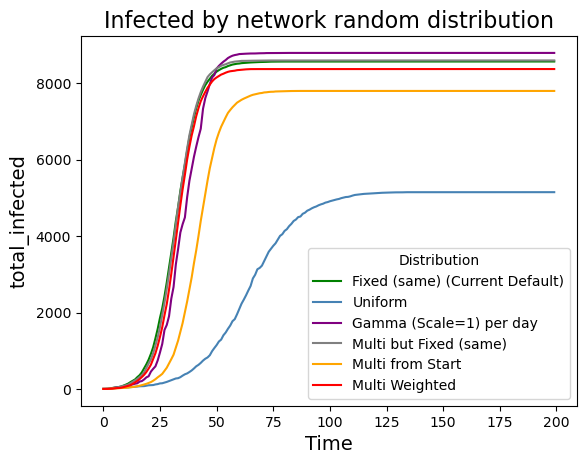

In [30]:
import matplotlib.pyplot as plt

plt.plot(timeseriesBaseline["total_infected"], label='Fixed (same) (Current Default)', color='green')
plt.plot(timeseriesUniform["total_infected"], label='Uniform', color='steelblue')
plt.plot(timeseriesGamma["total_infected"], label='Gamma (Scale=1) per day', color='purple')
plt.plot(timeseriesMulti["total_infected"], label='Multi but Fixed (same)', color='grey')
plt.plot(timeseriesMultiStart["total_infected"], label='Multi from Start', color='orange')
plt.plot(timeseriesMultiStartWeight["total_infected"], label='Multi Weighted', color='red')

#add legend
plt.legend(title='Distribution')

#add axes labels and a title
plt.ylabel('total_infected', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Infected by network random distribution', fontsize=16)

plt.show()

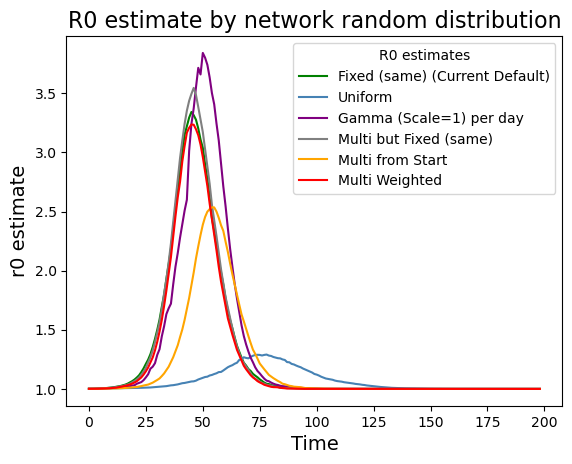

In [31]:
import matplotlib.pyplot as plt

plt.plot(r0Baseline["r0"], label='Fixed (same) (Current Default)', color='green')
plt.plot(r0Uniform["r0"], label='Uniform', color='steelblue')
plt.plot(r0Gamma["r0"], label='Gamma (Scale=1) per day', color='purple')
plt.plot(r0Multi["r0"], label='Multi but Fixed (same)', color='grey')
plt.plot(r0MultiStart["r0"], label='Multi from Start', color='orange')
plt.plot(r0MultiStartWeight["r0"], label='Multi Weighted', color='red')

#add legend
plt.legend(title='R0 estimates')

#add axes labels and a title
plt.ylabel('r0 estimate', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('R0 estimate by network random distribution', fontsize=16)

plt.show()

### What have we shown?
We have seen that introducing a greater degree of variability in the transmission multiplier within networks both on a per-day/per-type and per-type/entire-sim basis Can drastically alter the simulation outcome (See Uniform result).

We have also shown that varying occupation networks to select a value from a Gamma(1,1) distribution adds greater variability per network instance whilst maintaining a similar simulation output. (Gamma distribution per-day/per-type and per-type/entire-sim).

Finally we showed that weighting to a desired mean for just occupational networks with a large number of networks (200) instead of the default (5) produces similar population level simulation results whilst allowing for variability in types of occupational networks.

We have also shown that the Anderson and May estimate of R0 whereby R0 is proportional to the susceptible population (rather than both susceptible and infectives) remains true. The maximum r0 estimate for the original simulation and the final Multi Weighted (Gamma) simulation are comparable, as are the mean and variance of the r0 estimates per day of each simulation.

These results should allow us to proceed to tune simulations to reflect the real life types and variability of occupational networks, producing more accurate simulations at a more local level than is done today.

By adding in this level of programmability into the simulation's inputs we can move toward bridging the gap between per-person social mixing scoring or contact tracing via mobile devices and simulating based on these known mixing scores from the field.

Further work is required to define a reliable Social Mixing Score mechanism on mobile devices that is comparable between greatly variable mobile phones (i.e. phones with much higher transmission power and those with lower power), and using this mixing input by place (and thus network type and duration) to inform inputs to the OpenABM-Covid19 simulation.

### Future modifications
We need to do the same for the other network types, but currently there is no helper method for random or home networks as there is for occupation networks.

## Next Steps
Next I shall add a parameter for each network called distribution with the following options:-
- Fixed (as the original baseline)
- Uniform per network simulation step
- Uniform per network simulation
- Gamma per network simulation step (shape=1)
- Gamma per network simulation (shape=1)
- Weighted Gamma per network simulation step (shape=1)
- Weighted Gamma per network simulation (shape=1)

This will allow us to reproduce the above simulations via a simple parameters file rather than in Jupyter notebook. This will require modification to the OpenABM-Covid19 C code base.